In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
sys.path.append('../')

In [129]:
import numpy as np
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
import matplotlib
import tiledb
#import geoviews as gv
#gv.extension('bokeh')

In [65]:
from pyspatialkit.dataobjects.geopointcloud import GeoPointCloud
from pyspatialkit.storage.pointcloud.geopointcloudlayer import GeoPointCloudLayer
from pyspatialkit.storage.raster.georasterlayer import GeoRasterLayer
from pyspatialkit.storage.pointcloud.tiledbsparsebackend import AXIS_NAMES, AXIS_NAMES_SET
from pyspatialkit.crs.geocrs import GeoCrs, NoneCRS
from pyspatialkit.processing.image.interpolation import interpolate_along_axis
from pyspatialkit.spacedescriptors.geobox3d import GeoBox3d
from pyspatialkit.spacedescriptors.geobox2d import GeoBox2d
from pyspatialkit.spacedescriptors.georect import GeoRect
from pyspatialkit.tiling.geoboxtiler3d import GeoBoxTiler3d
from pyspatialkit.dataobjects.geoshape import GeoShape
from pyspatialkit.dataobjects.georaster import GeoRaster
from pyspatialkit.globals import DEFAULT_CRS, get_default_crs

In [5]:
from testing.utils import get_tmp_path, get_testdata_path

In [139]:
MIN_TREE_HEIGHT = 5
MIN_SATURATION = 0.05
MIN_BRIGHTNESS = 0.1
MAX_BRIGHTNESS = 0.7

In [16]:
dir_path_pc_dom = get_tmp_path() / 'geopointlcoudlayer_dom'
dir_path_pc_dgm = get_tmp_path() / 'geopointlcoudlayer_dgm'
dir_path_raster_dom = get_tmp_path() / 'raster_dom_layer'
dir_path_raster_dgm = get_tmp_path() / 'raster_dgm_layer'
dir_path_raster_rgb = get_tmp_path() / 'rgb_layer'
rgb_folder = get_testdata_path() / 'rgb'
dgm_folder = get_testdata_path() / 'dgm'
dom_folder = get_testdata_path() / 'dom'
crs = GeoCrs.from_epsg(25832)
bounds_2d = [733856, 5747905, 741405, 5752795]
#bounds_3d = [733856, 5747905, -1000, 741405, 5752795, 1000]
aoi_rect = GeoRect.from_bounds(bounds_2d, crs=crs)
pc_data_scheme = {'x': np.dtype('float64'), 'y': np.dtype('float64'), 'z': np.dtype('float64')}
#bounds = [0, 0, 0, 100.0, 100, 100]

In [8]:
#pclayer.delete_permanently()
#dem_layer.delete_permanently()
#rgb_layer.delete_permanently()

### Do only once...

In [9]:
pathlist = list(dom_folder.glob('**/*.xyz'))
pc = GeoPointCloud.from_xyz_file(pathlist[0], crs=crs)

In [13]:
pc_dom_layer = GeoPointCloudLayer(directory_path=dir_path_pc_dom, crs=crs, bounds=aoi_rect.bounds,
                                  data_scheme=pc_data_scheme, build_pyramid=False, point_density=1)
pathlist = dom_folder.glob('*.xyz')
for path in pathlist:
    pc = GeoPointCloud.from_xyz_file(path, crs=crs)
    pc_dom_layer.write_data(pc)

extent:[  7549.   4890. 120000.]
size[300. 300. 300.]


In [15]:
pc_dgm_layer = GeoPointCloudLayer(directory_path=dir_path_pc_dgm, crs=crs, bounds=aoi_rect.bounds,
                                 data_scheme=pc_data_scheme, build_pyramid=False, point_density=1)
pathlist = dgm_folder.glob('*.xyz')
for path in pathlist:
    pc = GeoPointCloud.from_xyz_file(path, crs=crs)
    pc_dgm_layer.write_data(pc)

extent:[  7549.   4890. 120000.]
size[300. 300. 300.]


In [18]:
raster_dom_layer = GeoRasterLayer(directory_path=dir_path_raster_dom, num_bands = 1, dtype=float, crs=crs, bounds=aoi_rect.bounds, build_pyramid=False)

../pyspatialkit/storage/geolayer.py:21: UserWarning: Layer already exists on storage. Loading existing layer. Ignoring intialization arguments!
  raise_warning("Layer already exists on storage. Loading existing layer. Ignoring intialization arguments!")


In [20]:
raster_dgm_layer = GeoRasterLayer(directory_path=dir_path_raster_dgm, num_bands = 1, dtype=float, crs=crs, bounds=aoi_rect.bounds, build_pyramid=False)

In [25]:
raster_rgb_layer = GeoRasterLayer(directory_path=dir_path_rgb, num_bands = 4, dtype=float, crs=crs, bounds=aoi_rect.bounds, build_pyramid=False)
pathlist = rgb_folder.glob('*.tif')
for path in pathlist:
    raster = GeoRaster.from_file(path)
    raster.data = raster.data.astype(float)
    raster_rgb_layer.write_data(raster)

../pyspatialkit/storage/geolayer.py:21: UserWarning: Layer already exists on storage. Loading existing layer. Ignoring intialization arguments!
  raise_warning("Layer already exists on storage. Loading existing layer. Ignoring intialization arguments!")


db request took: 0.14678335189819336
db request took: 0.15581464767456055


In [26]:
tree_aoi_rect = GeoRect.from_bounds([735053.4, 5749283.8, 735470.9, 5749680.7], crs = GeoCrs.from_epsg(25832))

In [27]:
rgb_raster = raster_rgb_layer.get_data(tree_aoi_rect)

db request took: 0.17167353630065918


../pyspatialkit/dataobjects/georaster.py:104: UserWarning: 3 channel image with dtype not np.uint8. Transformed dtype to np.uint8!!!
  


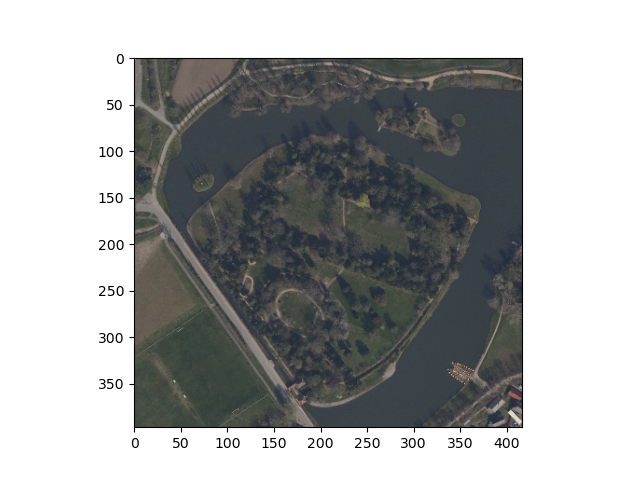

In [37]:
rgb_raster.plot()

In [83]:
dom_pc = pc_dom_layer.get_data(GeoBox2d.from_georect(tree_aoi_rect))

In [86]:
dgm_pc = pc_dgm_layer.get_data(GeoBox2d.from_georect(tree_aoi_rect))

In [98]:
rgb_raster.shape

(397, 417, 4)

In [113]:
dgm_raster = GeoRaster(rgb_raster.georect, np.zeros((*rgb_raster.shape[:2], 1)))
dgm_raster = dgm_pc.project_to_georaster(georaster=dgm_raster, value_field='height', interpolate_holes=True)

In [122]:
dom_raster = GeoRaster(rgb_raster.georect, np.zeros((*rgb_raster.shape[:2], 1)))
dom_raster = dom_pc.project_to_georaster(georaster=dom_raster, value_field='height', interpolate_holes=True)

In [127]:
height_above_ground_raster = dom_raster.copy()
height_above_ground_raster.data -= dgm_raster.data

In [148]:
MIN_TREE_HEIGHT = 3
MIN_SATURATION = 0.01
MIN_BRIGHTNESS = 0.01
MAX_BRIGHTNESS = 0.7

In [149]:
rgb = rgb_raster.data[:,:,:3]
am = np.argmax(rgb, axis=2)
mask = (am == 1)
relative_rgb = rgb.astype(float) / 255
brightness = relative_rgb.sum(axis=2) / 3
mask = mask & (brightness > MIN_BRIGHTNESS) & (brightness < MAX_BRIGHTNESS)
hsv = matplotlib.colors.rgb_to_hsv(relative_rgb)
mask = mask & (hsv[:,:, 1] > MIN_SATURATION)

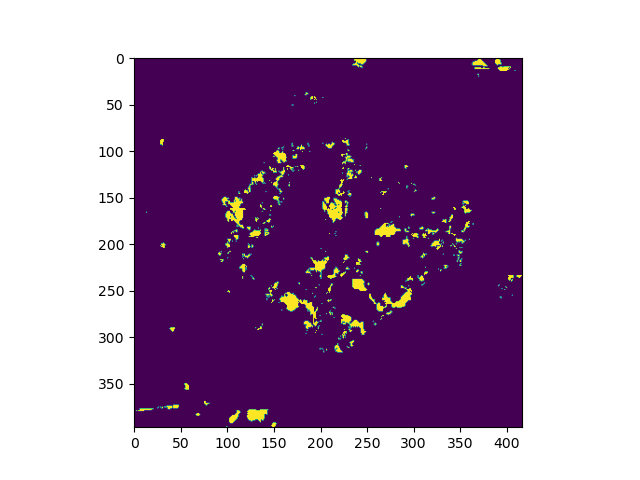

In [150]:
fig, ax = plt.subplots()
ax.imshow(mask & (height_above_ground_raster.data > MIN_TREE_HEIGHT).squeeze())

In [ ]:
def find_trees(rgb_raster: GeoRaster):
    bordered_rect = rgb_raster.georect.add_border()
    dom_pc = pc_dom_layer.get_data(GeoBox2d.from_georect(tree_aoi_rect))
    dgm_pc = pc_dgm_layer.get_data(GeoBox2d.from_georect(tree_aoi_rect))
    dgm_raster = GeoRaster(rgb_raster.georect, np.zeros((*rgb_raster.shape[:2], 1)))
    dgm_raster = dgm_pc.project_to_georaster(georaster=dgm_raster, value_field='height', interpolate_holes=True)
    dom_raster = GeoRaster(rgb_raster.georect, np.zeros((*rgb_raster.shape[:2], 1)))
    dom_raster = dom_pc.project_to_georaster(georaster=dom_raster, value_field='height', interpolate_holes=True)
    height_above_ground_raster = dom_raster.copy()
    height_above_ground_raster.data -= dgm_raster.data
    rgb = rgb_raster.data[:,:,:3]
    am = np.argmax(rgb, axis=2)
    mask = (am == 1)
    relative_rgb = rgb.astype(float) / 255
    brightness = relative_rgb.sum(axis=2) / 3
    mask = mask & (brightness > MIN_BRIGHTNESS) & (brightness < MAX_BRIGHTNESS)
    hsv = matplotlib.colors.rgb_to_hsv(relative_rgb)
    mask = mask & (hsv[:,:, 1] > MIN_SATURATION)

In [22]:
hm_raster = dem_layer.get_raster_for_rect(tree_aoi_rect)

db request took: 0.18206548690795898


In [27]:
hm_raster.plot()

In [23]:
rgb_raster = rgb_layer.get_raster_for_rect(tree_aoi_rect)

db request took: 0.19856953620910645


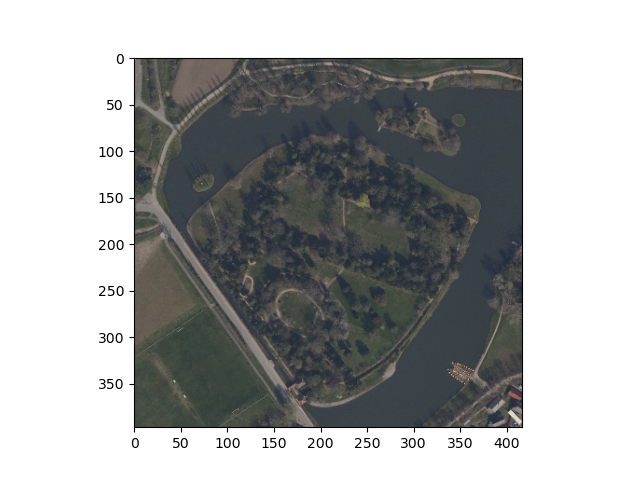

In [26]:
fig, ax = plt.subplots()
ax.imshow(rgb_raster.data[:,:,:3].astype(np.uint8))